Functions

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from sklearn.metrics import accuracy_score

def load_data(path):
    df = pd.read_csv(path)
    train_df, test_df = train_test_split(df, test_size=0.35, random_state=42)
    train_df, val_df,  = train_test_split(train_df, test_size=0.20, random_state=42)
    train_df = train_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    test_df = test_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    val_df = val_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
    return train_df, val_df, test_df

def encode_target(train):
    target_key = {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4,'Obesity_Type_II' : 5, 'Obesity_Type_III': 6}
    train['NObeyesdad'] = train['NObeyesdad'].map(target_key)
    return train

def make_gender_binary(train):
    train['Gender'] = train['Gender'].map({'Male':0, 'Female':1})

def datatypes(train):
    train['Weight'] = train['Weight'].astype(float)
    train['Age'] = train['Age'].astype(float)
    train['Height'] = train['Height'].astype(float)
    return train

def age_binning(train_df):
    train_df['Age_Group'] = pd.cut(train_df['Age'], bins=[0, 20, 30, 40, 50, train_df['Age'].max()], labels=['0-20', '21-30', '31-40', '41-50', '50+'])
    return train_df

def age_scaling_log(train_df):
    train_df['Age'] = train_df['Age'].astype(float)
    train_df['Log_Age'] = np.log1p(train_df['Age'])
    return train_df

def age_scaling_minmax(train_df):
    train_df['Age'] = train_df['Age'].astype(float)
    scaler_age = MinMaxScaler()
    train_df['Scaled_Age'] = scaler_age.fit_transform(train_df['Age'].values.reshape(-1, 1))
    return train_df, scaler_age

def weight_scaling_log(train_df):
    train_df['Weight'] = train_df['Weight'].astype(float)
    train_df['Log_Weight'] = np.log1p(train_df['Weight'])
    return train_df

def weight_scaling_minmax(train_df):
    train_df['Weight'] = train_df['Weight'].astype(float)
    scaler_weight = MinMaxScaler()
    train_df['Scaled_Weight'] = scaler_weight.fit_transform(train_df['Weight'].values.reshape(-1, 1))
    return train_df, scaler_weight

def height_scaling_log(train_df):
    train_df['Log_Height'] = np.log1p(train_df['Height'])
    return train_df

def height_scaling_minmax(train_df):
    scaler_height = MinMaxScaler()
    train_df['Scaled_Height'] = scaler_height.fit_transform(train_df['Height'].values.reshape(-1, 1))
    return train_df, scaler_height

def make_gender_binary(train):
    train['Gender'] = train['Gender'].map({'Female':1, 'Male':0})
    return train

def fix_binary_columns(train):
    Binary_Cols = ['family_history_with_overweight','FAVC', 'SCC','SMOKE']
    # if yes then 1 else 0
    for col in Binary_Cols:
        train[col] = train[col].map({'yes': 1, 'no': 0})
    return train

def freq_cat_cols(train):
    # One hot encoding
    cat_cols = ['CAEC', 'CALC']
    for col in cat_cols:
        train[col] = train[col].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    return train

def Mtrans(train):
    """
    Public_Transportation    8692
    Automobile               1835
    Walking                   231
    Motorbike                  19
    Bike                       16
    """
    # train['MTRANS'] = train['MTRANS'].map({'Public_Transportation': 3, 'Automobile': 5, 'Walking': 1, 'Motorbike': 4, 'Bike': 2})
    # dummify column
    train = pd.get_dummies(train, columns=['MTRANS'])
    return train


def other_features(train):
    train['BMI'] = train['Weight'] / (train['Height'] ** 2)
    # train['Age'*'Gender'] = train['Age'] * train['Gender']
    polynomial_features = PolynomialFeatures(degree=2)
    X_poly = polynomial_features.fit_transform(train[['Age', 'BMI']])
    poly_features_df = pd.DataFrame(X_poly, columns=['Age^2', 'Age^3', 'BMI^2', 'Age * BMI', 'Age * BMI^2', 'Age^2 * BMI^2'])
    train = pd.concat([train, poly_features_df], axis=1)
    return train


def test_pipeline(test, scaler_age, scaler_weight, scaler_height):
    test = datatypes(test)
    test = encode_target(test)
    test = age_binning(test)
    test = age_scaling_log(test)
    test['Scaled_Age'] = scaler_age.transform(test['Age'].values.reshape(-1, 1))
    test = weight_scaling_log(test)
    test['Scaled_Weight'] = scaler_weight.transform(test['Weight'].values.reshape(-1, 1))
    test = height_scaling_log(test)
    test['Scaled_Height'] = scaler_height.transform(test['Height'].values.reshape(-1, 1))
    test = make_gender_binary(test)
    test = fix_binary_columns(test)
    test = freq_cat_cols(test)
    test = Mtrans(test)
    test = other_features(test)

    return test

def train_model(params, X_train, y_train):
    lgb_train = lgb.Dataset(X_train, y_train)
    model = lgb.train(params, lgb_train, num_boost_round=1000)
    return model

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_pred = [np.argmax(y) for y in y_pred]
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

def objective(trial, X_train, y_train):
    params = {
        'objective': 'multiclass',
        'num_class': 7,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 0.95),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 0.95),
        'verbosity': -1
    }

    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = train_model(params, X_tr, y_tr)
        accuracy = evaluate_model(model, X_val, y_val)
        scores.append(accuracy)

    return np.mean(scores)

def optimize_hyperparameters(X_train, y_train, n_trials=2):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=n_trials)
    return study.best_params

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score, f1_score, auc,classification_report
from scipy.stats import ks_2samp

from sklearn.preprocessing import label_binarize,OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from itertools import cycle

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
import shap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA

import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd

# def load_data(path):
#     df = pd.read_csv(path)
#     # arham check this later
#     # original = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')
#     # split to train test
#     train_df, test_df = train_test_split(df, test_size=0.35, random_state=42)
#     train_df = train_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
#     test_df = test_df.drop(['id'], axis=1).drop_duplicates().reset_index(drop=True)
#     return train_df, test_df

def corr_heat_map(df,scale=1) :
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(10//scale, 8//scale))

    # Define a custom color palette
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": 0.7})

    plt.title('Correlation Heatmap')


def EDA_Report(): 
    print("\n","="*25,"Train","="*25)
    display(train.describe().T)
    display(train.info())
    
    print("\n","="*25,"Test","="*25)
    display(test.describe().T)
    display(test.info())


    plt.figure(figsize=(20,7))
    corr_heat_map(train[num_col],2)
    corr_heat_map(test[num_col],2)
    plt.show()

    plt.figure(figsize=(30,30))
    temp=num_col.copy()
    temp.extend([target])
    sns.pairplot(train[sorted(temp)],hue=target)
    plt.show()

    plt.figure(figsize=(50,4))

    x=1
    for i in num_col : 
        
        plt.subplot(1,8,x)
        sns.violinplot(
            data=train,
            x=target,
            y=i
        )
        plt.xticks(rotation=45)
        x+=1

    plt.show()

    temp = train.copy()
    plt.figure(figsize=(30,12))
    plot_num = 1
    for i in ['Age', 'Height', 'FCVC', 'NCP', 'FAF', 'TUE'] :
        
        sc = StandardScaler()
        p =  PCA(n_components=2,random_state=42)
        temp['Weight2'] = temp['Weight']//5
        
        x=['Weight2','CH2O',i]
        temp[['pca_1_wt_ch20_'+i+"_1",'pca_1_wt_ch20_'+i+"_2"]] = p.fit_transform(temp[x])
        
        plt.subplot(2,3,plot_num)
        plt.title(x)
        sns.scatterplot(x= temp['pca_1_wt_ch20_'+i+"_1"],
                        y=temp['pca_1_wt_ch20_'+i+"_2"],
                        hue=temp[target],
                        palette = 'pastel',
                        legend = 'full'
        )
        sns.regplot(x= temp['pca_1_wt_ch20_'+i+"_1"],
                    y=temp['pca_1_wt_ch20_'+i+"_2"],
                    scatter=False
        )
        
        plot_num+=1

    plt.show()


def optimization_function(trial) : 
    
    lgbParams = {
        'num_class': 7,
        'random_state': 42,
        'metric': 'multi_logloss',
        "boosting_type": "gbdt",
        'objective': 'multiclass',
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-1, 10.0),
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
    }
    
    lgb_model=lgb.LGBMClassifier(**lgbParams)
    
#     skf = StratifiedKFold(n_splits=5,shuffle=False, random_state=None)
#     accuracy = cross_val_score(lgb_model,X_train,y_train, cv=skf,scoring='accuracy')
#     print("="*50,'\nValidation Accuracy:', accuracy.mean())

    lgb_model.fit(X_train,y_train)
    
    acc = accuracy_score(y_val,lgb_model.predict(X_val))
    
    return acc

Autogluon probs

In [17]:
path = '/Users/arham/Downloads/Projects/01-Dataset/01-Data-for-model-building/train.csv'
train_df, val_df, test_df = load_data(path)

train_df = datatypes(train_df)
train_df = encode_target(train_df)
train_df = age_binning(train_df)
train_df, scaler_age = age_scaling_minmax(train_df)
train_df = age_scaling_log(train_df)
train_df, scaler_weight = weight_scaling_minmax(train_df)
train_df = weight_scaling_log(train_df)
train_df, scaler_height = height_scaling_minmax(train_df)
train_df = height_scaling_log(train_df)
train_df = make_gender_binary(train_df)
train_df = fix_binary_columns(train_df)
train_df = freq_cat_cols(train_df)
train_df = Mtrans(train_df)
train_df = other_features(train_df)

val_df = test_pipeline(val_df, scaler_age, scaler_weight, scaler_height)
test_df = test_pipeline(test_df, scaler_age, scaler_weight, scaler_height)

Target = 'NObeyesdad'
features = train_df.columns.drop(Target)

features = ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'Age_Group', 
       'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking', 'BMI', 'Age^2',
       'Age^3', 'BMI^2', 'Age * BMI', 'Age * BMI^2', 'Age^2 * BMI^2'] 
#'Scaled_Age', 'Log_Age', 'Scaled_Weight', 'Log_Weight', 'Scaled_Height', 'Log_Height',

X_train = train_df[features]
y_train = train_df[Target]
X_val = val_df[features]
y_val = val_df[Target]
X_test = test_df[features]
y_test = test_df[Target]

#combine X_train and y_train as one dataframe
tr = pd.concat([X_train, y_train], axis=1)
te = pd.concat([X_test, y_test], axis =1)
va = pd.concat([X_val, y_val], axis = 1)


from autogluon.tabular import TabularPredictor
# Train AutoGluon model
predictor = TabularPredictor(label=Target).fit(train_data=tr, tuning_data=va)
# Evaluate on validation data
performance = predictor.evaluate(va)
# Make predictions on test data
y_pred = predictor.predict(te)
# Print evaluation metrics
print(performance)


# Make predictions on train, validation, and test data
y_pred_train = predictor.predict(tr)
y_pred_va = predictor.predict(va)
y_pred_test = predictor.predict(te)

# Get prediction probabilities for each class
y_probabilities_train = predictor.predict_proba(tr)
y_probabilities_va = predictor.predict_proba(va)
y_probabilities_test = predictor.predict_proba(te)

# add to tr, te, va
test = pd.concat([te, y_probabilities_test.iloc[:, -7:]], axis=1)
train = pd.concat([tr, y_probabilities_train.iloc[:, -7:]], axis=1)
val = pd.concat([va, y_probabilities_va.iloc[:, -7:]], axis=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20240421_234150"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240421_234150"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.0.0: Fri Sep 15 14:42:57 PDT

{'accuracy': 0.9107076695072249, 'balanced_accuracy': 0.903291645825612, 'mcc': 0.8955040990427827}


In [18]:
train

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,Age * BMI^2,Age^2 * BMI^2,NObeyesdad,0,1,2,3,4,5,6
0,1,21.000000,1.550000,51.000000,0,1,3.000000,1.0,2,0,...,445.785640,450.623213,0,0.797175,0.196596,0.005617,0.000520,0.000032,0.000019,0.000040
1,0,20.000000,1.700000,80.000000,1,1,2.000000,3.0,1,0,...,553.633218,766.274350,3,0.000041,0.001926,0.047782,0.948167,0.002041,0.000018,0.000025
2,1,18.000000,1.600000,60.000000,1,1,2.000000,3.0,1,0,...,421.875000,549.316406,1,0.011628,0.953612,0.033047,0.001538,0.000150,0.000005,0.000020
3,1,26.000000,1.632983,111.720238,1,1,3.000000,3.0,1,0,...,1089.285877,1755.242193,6,0.000001,0.000002,0.000008,0.000018,0.000172,0.000040,0.999759
4,1,21.682636,1.748524,133.845064,1,1,3.000000,3.0,1,0,...,949.229536,1916.541944,6,0.000001,0.000001,0.000004,0.000012,0.000092,0.000058,0.999831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10788,0,18.000000,1.780000,108.000000,1,1,2.000000,3.0,1,0,...,613.558894,1161.896656,4,0.000007,0.000014,0.000035,0.000287,0.998704,0.000949,0.000005
10789,1,26.000000,1.641601,111.830924,1,1,3.000000,3.0,1,0,...,1078.946835,1722.080284,6,0.000001,0.000002,0.000007,0.000020,0.000154,0.000059,0.999757
10790,0,21.000000,1.770000,75.000000,0,1,3.000000,3.0,2,0,...,502.729101,573.098750,2,0.000212,0.341897,0.657261,0.000391,0.000052,0.000019,0.000168
10791,0,29.669219,1.774644,105.966894,1,1,2.934671,3.0,1,0,...,998.283353,1132.127734,4,0.000621,0.000067,0.000338,0.004232,0.936736,0.057409,0.000597


Using Previous Probabilities for lgbm


In [19]:
# combine train and val
combined_train_val = pd.concat([train, val], ignore_index=True)

target = 'NObeyesdad'
num_col = []
cat_col = []

for i in train.columns.drop([target]) : 
    
    if train[i].dtype == 'object' : 
        cat_col.append(i)
        
    else : 
        num_col.append(i)

# print("Numerical Columns : ", *num_col,"\n",sep="\n")
# print("Categorical Columns : ", *cat_col,sep="\n")

# EDA_Report()

train = pd.get_dummies(train, columns=cat_col)
test = pd.get_dummies(test, columns=cat_col)
target = 'NObeyesdad'
le = LabelEncoder()
train['NObeyesdad'] = le.fit_transform(train['NObeyesdad'])

X_train, X_val, y_train, y_val = train_test_split(train.drop([target],axis=1),train[target],test_size=0.2,random_state=42)
X_train.shape , y_train.shape, X_val.shape, y_val.shape 

import optuna
ran_optuna = False

if ran_optuna : 

    print('Number of finished trials:', len(study.trials))

    print('Best trial:', study.best_trial.params)

    optuna.visualization.plot_param_importances(study)

    study.trials_dataframe().sort_values('value',ascending=False)

    optuna.visualization.plot_slice(study)

# 100 trials 
# {'objective': 'multiclassova', 'learning_rate': 0.04641200998070569, 'n_estimators': 587, 'reg_alpha': 0.0065043557057678746, 'reg_lambda': 4.460933310544669, 'max_depth': 7, 'colsample_bytree': 0.6833315654013498, 'subsample': 0.8193986843950917, 'min_child_samples': 15}

if ran_optuna : 
    lgbParams = study.best_trial.params

else :
    
#     # 100- traials with PCA seed = None
#     lgbParams = {
#         'objective': 'multiclassova', 
#         'learning_rate': 0.04641200998070569, 
#         'n_estimators': 587, 
#         'reg_alpha': 0.0065043557057678746, 
#         'reg_lambda': 4.460933310544669, 
#         'max_depth': 7, 'colsample_bytree': 0.6833315654013498, 
#         'subsample': 0.8193986843950917, 
#         'min_child_samples': 15
#     }
    
    
    # Moaz HyperParams
    lgbParams = {
        "objective": "multiclass",          # Objective function for the model
        "metric": "multi_logloss",          # Evaluation metric
        "verbosity": -1,                    # Verbosity level (-1 for silent)
        "boosting_type": "gbdt",            # Gradient boosting type
        "random_state": 42,       # Random state for reproducibility
        "num_class": 7,                     # Number of classes in the dataset
        'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
        'n_estimators': 500,                # Number of boosting iterations
        'lambda_l1': 0.009667446568254372,  # L1 regularization term
        'lambda_l2': 0.04018641437301800,   # L2 regularization term
        'max_depth': 10,                    # Maximum depth of the trees
        'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
        'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
        'min_child_samples': 26             # Minimum number of data needed in a leaf
    }

In [20]:
fixed_params = {
    'boosting_type': 'gbdt',
    'num_class': 7,
    'random_state': 42,
    'metric': 'multi_logloss',
}

for i in fixed_params.keys() : 

    lgbParams[i] = fixed_params[i]

lgbParams
lgb_model_final = lgb.LGBMClassifier(**lgbParams)
lgb_model_final = lgb_model_final.fit(X_train, y_train)
y_pred = lgb_model_final.predict(X_val)
accuracy_score(y_val, y_pred) 

0.9976841130152848

In [21]:
y_pred_proba = lgb_model_final.predict_proba(X_val)

In [22]:
X_val = pd.concat([X_val.reset_index(),pd.DataFrame({'actual':le.inverse_transform(y_val),'guess':le.inverse_transform(y_pred)})],axis=1)
X_val['dummy'] = 1
X_val.pivot_table(index='actual',columns='guess',values='dummy',aggfunc='sum')

guess,0,1,2,3,4,5,6
actual,,,,,,,
0,255.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,342.0,1.0,NaN,NaN,NaN,NaN
2,NaN,1.0,252.0,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,270.0,NaN,NaN,NaN
4,1.0,NaN,NaN,NaN,323.0,NaN,NaN
5,NaN,NaN,NaN,NaN,1.0,326.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,386.0


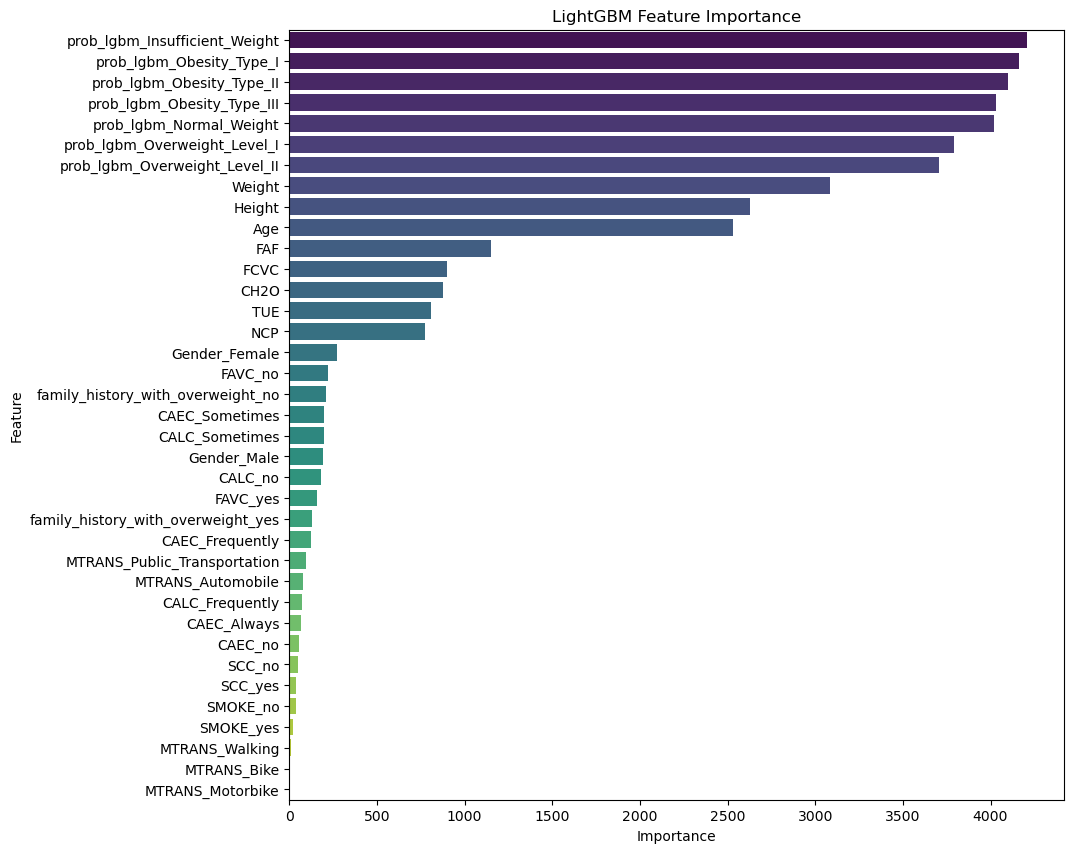

In [16]:
def plot_lgbm_feature_importance(model, feature_names=None, top_n=10, plot=True):

    # Get feature importance
    feature_importance = model.feature_importances_
    
    # Get feature names
    if feature_names is None:
        feature_names = model.feature_name()

    # Create DataFrame with feature names and importance scores
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Sort by importance and select top features
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)#.head(top_n)

    # Plot the feature importance
    if plot:
        plt.figure(figsize=(10, 10))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title('LightGBM Feature Importance')
        plt.show()

    return feature_importance_df

feature_importance_df = plot_lgbm_feature_importance(lgb_model_final,feature_names=X_train.columns)

SHAP

In [23]:
import shap
def plot_shap_summary(model, X, plot_type='bar', plot=True):
    
    # Create a SHAP explainer object
    explainer = shap.TreeExplainer(model)

    # Calculate SHAP values
    shap_values = explainer.shap_values(X)

    return shap_values

shap_values = plot_shap_summary(lgb_model_final, pd.DataFrame(data=X_train,columns=X_train.columns))


['Insufficient_Weight']


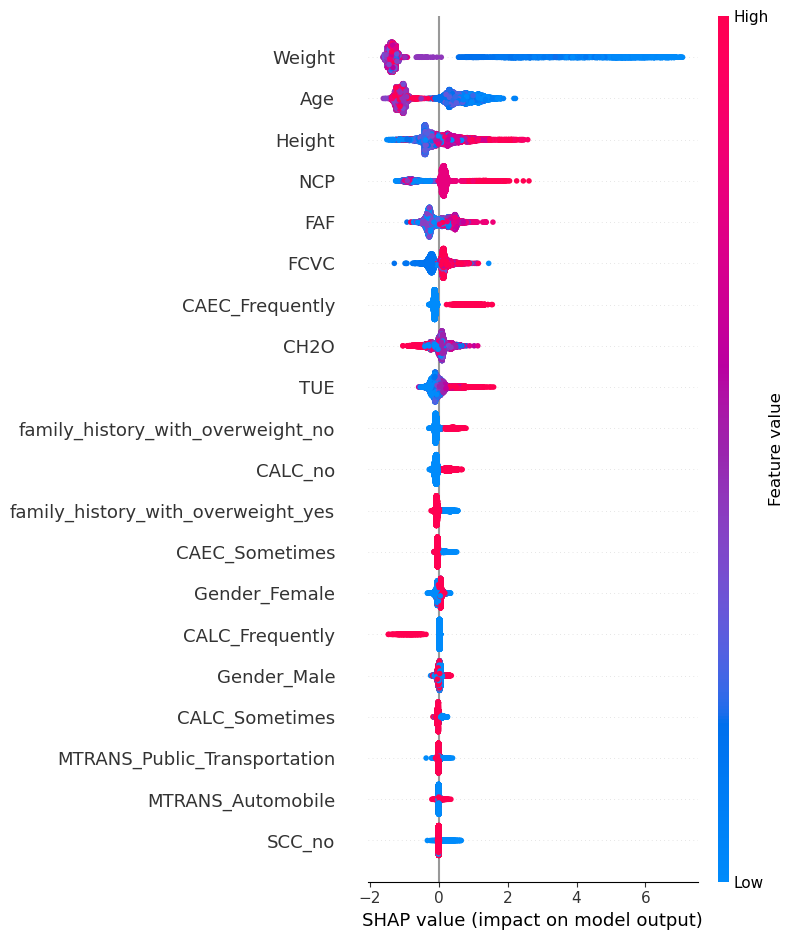

['Normal_Weight']


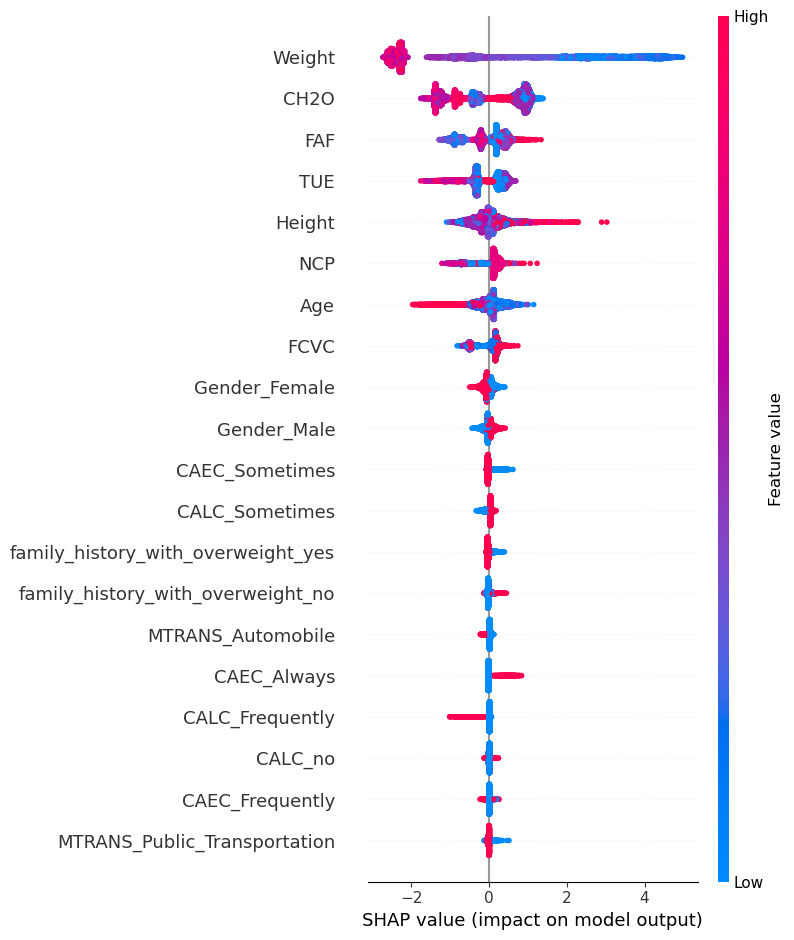

['Obesity_Type_I']


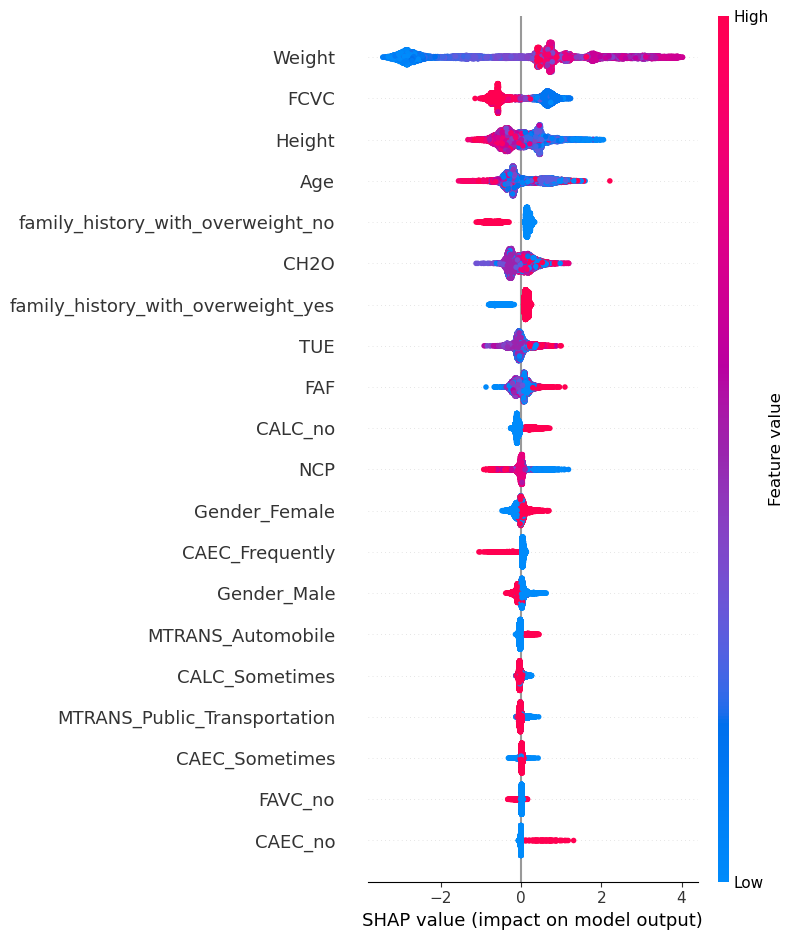

['Obesity_Type_II']


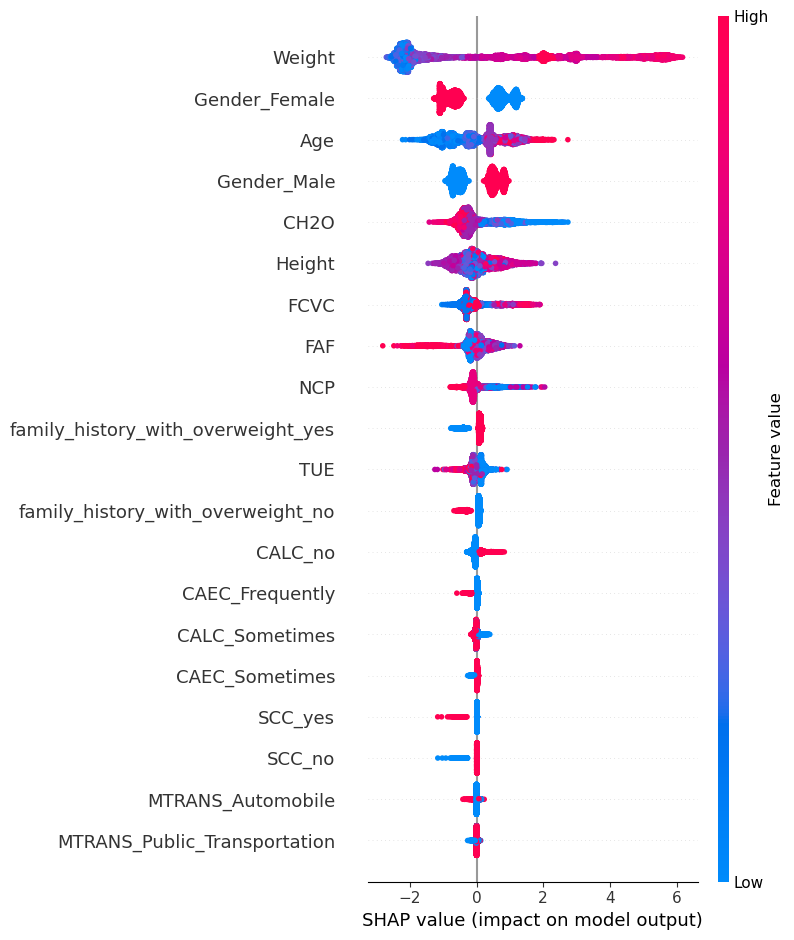

['Obesity_Type_III']


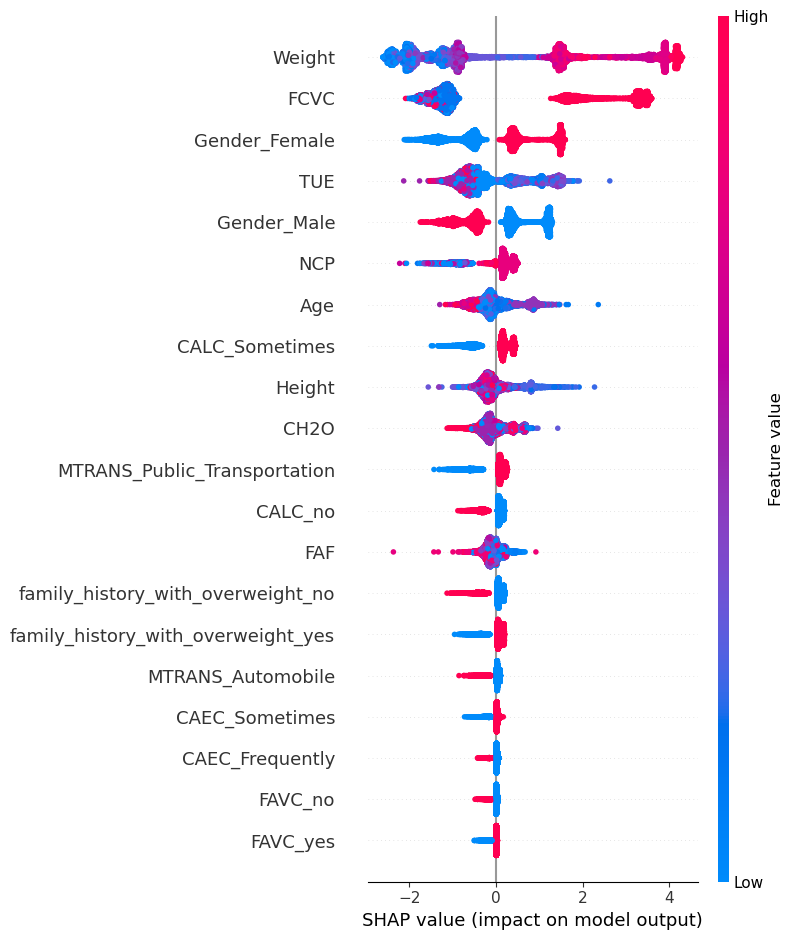

['Overweight_Level_I']


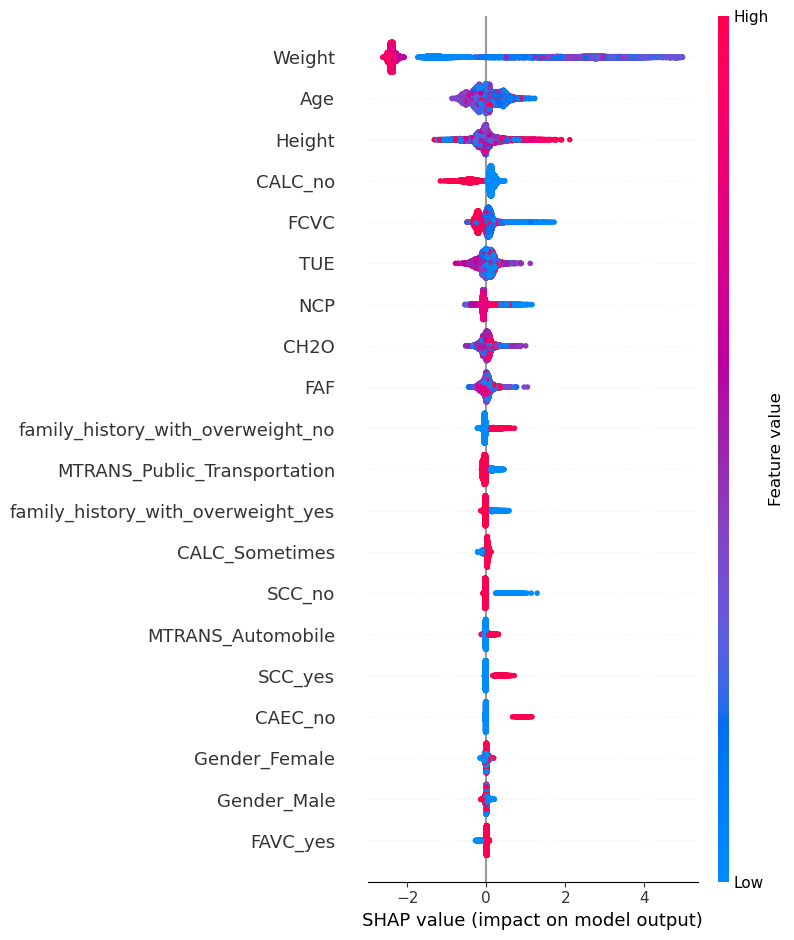

['Overweight_Level_II']


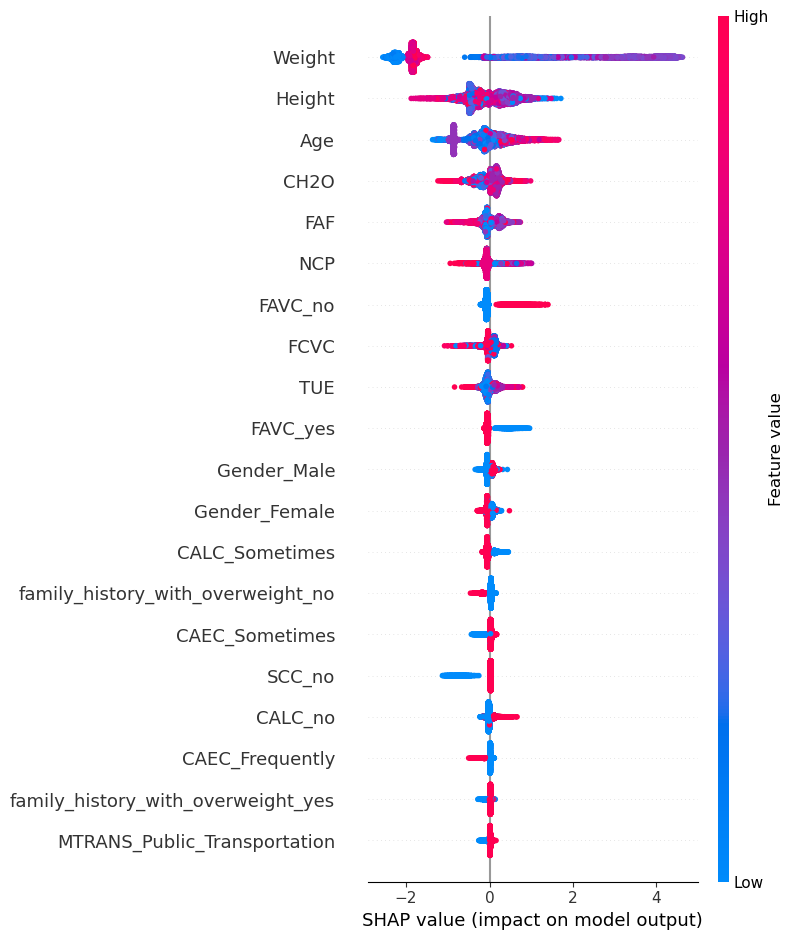

In [34]:
for x in range(len(shap_values)) : 
    print("="*50)
    print(le.inverse_transform([x]))
    shap.summary_plot(shap_values[x], pd.DataFrame(data=X_train,columns=X_train.columns)) #, plot_type=plot_type, show=False)

## Threshold optimization

In [37]:
threshold_optimization = True
run_optuna_threshold = True

In [38]:
import optuna

def objective(trial):

    # Define the thresholds for each class
    thresholds = {}
    for i in range(num_classes):
        thresholds[f'threshold_{i}'] = trial.suggest_uniform(f'threshold_{i}', 0.0, 1.0)

    # Apply the thresholds to convert probabilities to predictions
    y_pred = apply_thresholds(y_pred_proba, thresholds)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy  

def apply_thresholds(y_proba, thresholds):
    # Apply the specified thresholds to convert probabilities to predicted labels
    y_pred_labels = np.argmax(y_proba, axis=1)
    for i in range(y_proba.shape[1]):
        y_pred_labels[y_proba[:, i] > thresholds[f'threshold_{i}']] = i

    return y_pred_labels

In [39]:
if run_optuna_threshold : 
    num_classes = 7
    y_pred_proba = y_pred_proba  # Example: replace with actual y_pred_proba
    y_val = y_val  # Example: replace with actual y_val

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)

    # Get the best thresholds
    best_thresholds = study.best_params
    print("Best Thresholds:", best_thresholds)
    print("Best Value:", study.best_value)
    threshold_optimization = True

[I 2024-04-21 14:11:58,595] A new study created in memory with name: no-name-277aca92-3e00-4360-b087-5ee46abd5e3a
[I 2024-04-21 14:11:58,669] Trial 0 finished with value: 0.9007039644312709 and parameters: {'threshold_0': 0.5498366489779771, 'threshold_1': 0.6042017429240846, 'threshold_2': 0.6034445004405496, 'threshold_3': 0.29869225109833275, 'threshold_4': 0.9351499267122496, 'threshold_5': 0.22612144063047523, 'threshold_6': 0.3581149564492284}. Best is trial 0 with value: 0.9007039644312709.
[I 2024-04-21 14:11:58,679] Trial 1 finished with value: 0.8721748795850315 and parameters: {'threshold_0': 0.15374597934443257, 'threshold_1': 0.8830838983866507, 'threshold_2': 0.24186450936006632, 'threshold_3': 0.5011403906338872, 'threshold_4': 0.7316368358679999, 'threshold_5': 0.9961113166331248, 'threshold_6': 0.10939815092943816}. Best is trial 0 with value: 0.9007039644312709.
[I 2024-04-21 14:11:58,695] Trial 2 finished with value: 0.8532789922193404 and parameters: {'threshold_0':

Best Thresholds: {'threshold_0': 0.4578427135126842, 'threshold_1': 0.6940184555354634, 'threshold_2': 0.29979967873896424, 'threshold_3': 0.7383143766672385, 'threshold_4': 0.9985308499941101, 'threshold_5': 0.414277415993026, 'threshold_6': 0.40394321772067593}
Best Value: 0.9088551315301964


In [40]:
if threshold_optimization : 
    if run_optuna_threshold == False : 
        best_thresholds = {'threshold_0': 0.724201213234911, 'threshold_1': 0.6161299800571379, 'threshold_2': 0.29138887902587174, 'threshold_3': 0.3145837593497076, 'threshold_4': 0.8469398340837189, 'threshold_5': 0.6800824438387787, 'threshold_6': 0.35886959729223455}


In [51]:
# y_test_label = lgb_model_final.predict(X_test)

# display(len(y_test_label))

# test['NObeyesdad'] = y_test_label
# out = test[['id','NObeyesdad']]
# out.NObeyesdad = le.inverse_transform(out.NObeyesdad)
# display(out.head(5))

# out.to_csv("submission_non_threshold_opt.csv",index=False)

# if threshold_optimization : 
    
#     y_test_label = lgb_model_final.predict_proba(X_test)
    
#     y_test_label = apply_thresholds(y_test_label, best_thresholds)

#     display(len(y_test_label))
    
#     test['NObeyesdad'] = y_test_label
#     out = test[['id','NObeyesdad']]
#     out.NObeyesdad = le.inverse_transform(out.NObeyesdad)
#     display(out.head(5))

#     out.to_csv("submission_threshold_opt.csv",index=False)

misclassifcaition investigation

In [42]:
feature_importance_df.head(5).Feature

1    Height
2    Weight
0       Age
6       FAF
5      CH2O
Name: Feature, dtype: object

In [43]:
temp = train.copy()

In [44]:
temp.shape[0]


13492

In [45]:
shap_values = plot_shap_summary(lgb_model_final, pd.DataFrame(data=temp.drop(target,axis=1),columns=temp.columns.drop(target)))

In [46]:
shap_magnitude = np.linalg.norm(shap_values,axis=2)
threshold = 6.5
outlier_mask = np.max(shap_magnitude, axis=0) > threshold

In [ ]:
# Use numpy's unique function to get unique values and their counts
unique_values, counts = np.unique(outlier_mask, return_counts=True)

# Combine unique values and counts into a dictionary
value_counts = dict(zip(unique_values, counts))

# Print the value counts
print(value_counts)

In [47]:
y_test_label = lgb_model_final.predict(temp.drop(target,axis=1))
temp['NObeyesdad_pred'] = y_test_label
temp['outlier_mask'] = outlier_mask
temp['miss_class'] = temp['NObeyesdad_pred']!=temp['NObeyesdad']
temp2 = temp[temp['miss_class']]
temp['outlier_mask']
temp3 = temp[temp['outlier_mask']]

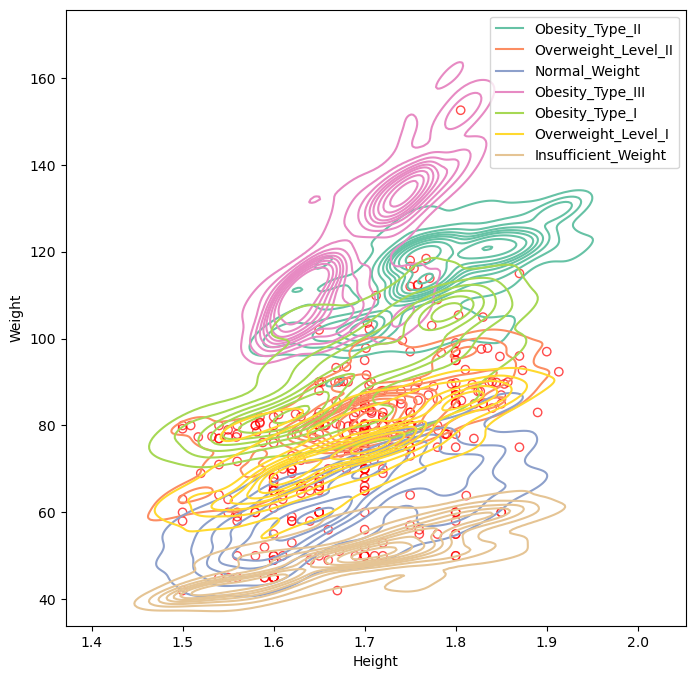

In [48]:
# First joint plot
plt.figure(figsize=(8, 8))

# Plot the main scatter plot
sns.kdeplot(x=temp.Height, y=temp.Weight, hue=le.inverse_transform(temp[target]), palette='Set2')

# Add the second set of points as red circles
sns.scatterplot(x='Height', y='Weight', data=temp2, color='red', edgecolor='red', marker='o', linewidth=1, alpha=0.7, facecolors='none')

plt.show()

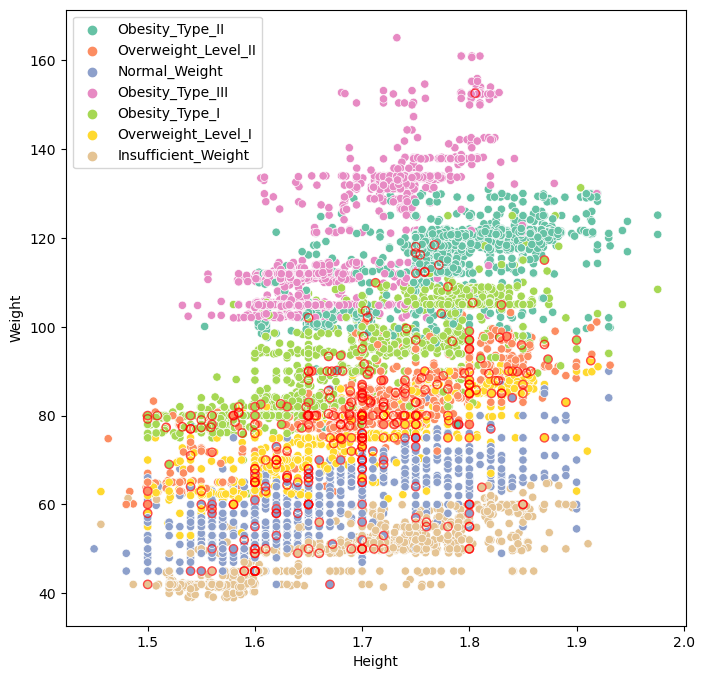

In [49]:
# First joint plot
plt.figure(figsize=(8, 8))

# Plot the main scatter plot
sns.scatterplot(x=temp.Height, y=temp.Weight, hue=le.inverse_transform(temp[target]), palette='Set2')

# Add the second set of points as red circles
sns.scatterplot(x='Height', y='Weight', data=temp2, color='red', edgecolor='red', marker='o', linewidth=1, alpha=0.7, facecolors='none')

plt.show()

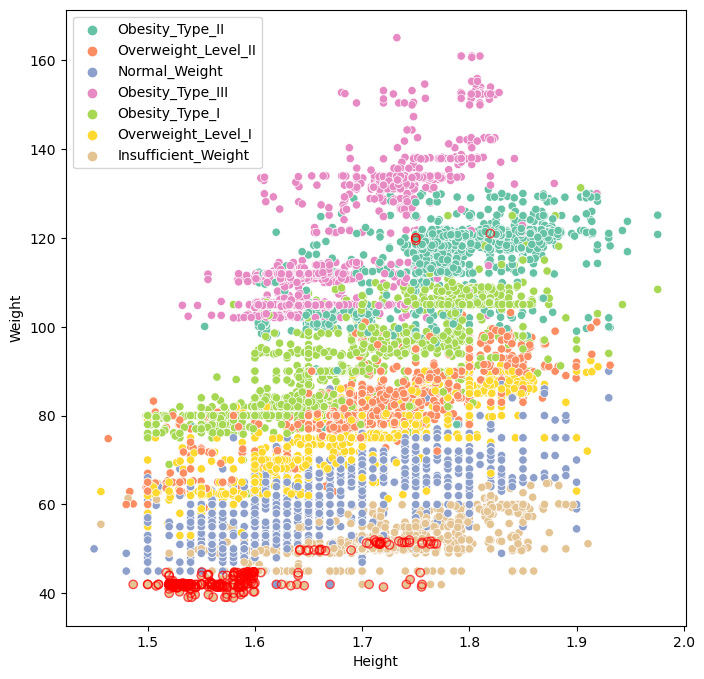

In [50]:
# First joint plot
plt.figure(figsize=(8, 8))

# Plot the main scatter plot
sns.scatterplot(x=temp.Height, y=temp.Weight, hue=le.inverse_transform(temp[target]), palette='Set2')

# Add the second set of points as red circles
sns.scatterplot(x='Height', y='Weight', data=temp3, color='red', edgecolor='red', marker='o', linewidth=1, alpha=0.7, facecolors='none')

plt.show()